In [1]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import re
from scipy.stats import entropy
from utilities import plot_boxplot, plot_hist
from sklearn import preprocessing

In [2]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'

In [93]:
DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'

In [96]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean.csv', sep='#')

In [20]:
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

# How many tweets were published by the user?

In [99]:
df_indicators = pd.DataFrame({'n_tweets' : df_tweets.groupby(['user_id'] ).size()}).reset_index()

In [100]:
df_indicators

,user_id,n_tweets
0,000vk,1
1,0013tom,1
2,001gi,1
3,001rx,1
4,00201f,1
...,...,...
140538,zzyb,1
140539,zzyd6,1
140540,zzyyu,1
140541,zzz9v,1


# How many tweets are published by the user in a given period of time?

In [101]:
for y in range(2012, 2021):
  df_indicators[str(y) + "_tweets"] = 0

df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      140543 non-null  object
 1   n_tweets     140543 non-null  int64 
 2   2012_tweets  140543 non-null  int64 
 3   2013_tweets  140543 non-null  int64 
 4   2014_tweets  140543 non-null  int64 
 5   2015_tweets  140543 non-null  int64 
 6   2016_tweets  140543 non-null  int64 
 7   2017_tweets  140543 non-null  int64 
 8   2018_tweets  140543 non-null  int64 
 9   2019_tweets  140543 non-null  int64 
 10  2020_tweets  140543 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 11.8+ MB


In [102]:
for y in range(2012,2021):
  # Filter all tweets published in a certain year
  tweets_by_y = df_tweets[land(df_tweets['created_at'] >= (str(y)+"-01-01"),
                               df_tweets['created_at'] <= (str(y)+"-12-31"))][['user_id','created_at']]

  # Count tweets of users in that year
  gby = pd.DataFrame({'n_tweets' : tweets_by_y.groupby( [ 'user_id'] ).size()}).reset_index()

  # Transform it in a dictionary
  gby = dict(zip(gby.user_id, gby.n_tweets))

  # Select users to modify and update them
  df_indicators.loc[df_indicators['user_id'].isin(gby.keys()), str(y)+'_tweets'] = list(gby.values())

<BarContainer object of 9 artists>

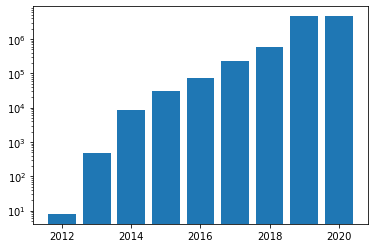

In [103]:
years_col_list = [str(y)+'_tweets' for y in range(2012,2021)]
sum_list = [df_indicators[y].sum() for y in years_col_list]
plt.bar(range(2012,2021), sum_list, log=True)

# Total number of tweets

In [104]:
tot_n_tweets = df_tweets.shape[0]
tot_n_tweets

10187873

# Total number of likes and comments and retweets

In [105]:
total_favorite = df_tweets.favorite_count.sum()
total_favorite

5386511

In [106]:
total_replies = df_tweets.reply_count.sum()
total_replies

886527

In [107]:
total_retweets = df_tweets.retweet_count.sum()
total_retweets

366372232

# Ratio between the number of tweets and the number of likes

In [108]:
ratio_tweets_fav = len(df_tweets) / total_favorite
ratio_tweets_fav

1.8913677146486845

## Ratio between the number of tweets and the number of retweets

In [109]:
ratio_tweets_rt = len(df_tweets) / total_retweets
ratio_tweets_rt

0.027807437655373402

## Ratio between the number of tweets and the number of comments

In [110]:
ratio_tweets_replies = len(df_tweets) / total_replies
ratio_tweets_replies

11.491892519911971

# Average length of the tweets per user

In [111]:
df_tweets['length'] = df_tweets.text.astype(str).apply(len)

<AxesSubplot:>

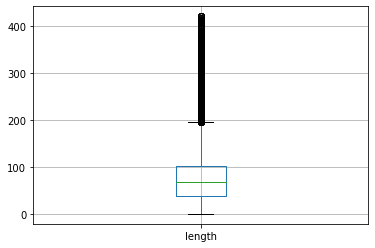

In [112]:
df_tweets.boxplot('length')

In [113]:
len_groupby = df_tweets.groupby('user_id').agg({'length':'mean'})

In [114]:
df_indicators['mean_length'] = len_groupby.length.values
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      140543 non-null  object 
 1   n_tweets     140543 non-null  int64  
 2   2012_tweets  140543 non-null  int64  
 3   2013_tweets  140543 non-null  int64  
 4   2014_tweets  140543 non-null  int64  
 5   2015_tweets  140543 non-null  int64  
 6   2016_tweets  140543 non-null  int64  
 7   2017_tweets  140543 non-null  int64  
 8   2018_tweets  140543 non-null  int64  
 9   2019_tweets  140543 non-null  int64  
 10  2020_tweets  140543 non-null  int64  
 11  mean_length  140543 non-null  float64
dtypes: float64(1), int64(10), object(1)
memory usage: 12.9+ MB


In [115]:
df_indicators.max()

user_id         zzza
n_tweets        3447
2012_tweets        7
2013_tweets      169
2014_tweets      885
2015_tweets     1697
2016_tweets     2824
2017_tweets     3250
2018_tweets     3202
2019_tweets     3360
2020_tweets     3350
mean_length    365.0
dtype: object

# Average number of special characters in the tweets per user

In [116]:
df_tweets['special_chars'] = df_tweets.text.astype(str).apply(lambda text: len(re.findall("(?=\W)(?=\S)", text)))

In [117]:
len_groupby = df_tweets.groupby('user_id').agg({'special_chars':'mean'})

df_indicators['mean_special_chars'] = len_groupby.special_chars.values
df_indicators

,user_id,n_tweets,2012_tweets,2013_tweets,2014_tweets,2015_tweets,2016_tweets,2017_tweets,2018_tweets,2019_tweets,2020_tweets,mean_length,mean_special_chars
0,000vk,1,0,0,0,0,0,0,0,0,1,110.0,9.0
1,0013tom,1,0,0,0,0,0,0,1,0,0,104.0,5.0
2,001gi,1,0,0,0,0,0,0,0,0,1,15.0,0.0
3,001rx,1,0,0,0,0,0,0,0,0,1,47.0,0.0
4,00201f,1,0,0,0,0,0,0,0,1,0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140538,zzyb,1,0,0,0,0,0,0,0,1,0,3.0,0.0
140539,zzyd6,1,0,0,0,0,0,0,0,1,0,66.0,0.0
140540,zzyyu,1,0,0,0,0,0,0,0,0,1,64.0,1.0
140541,zzz9v,1,0,0,0,0,0,0,0,1,0,3.0,0.0


# File Checkpoint

In [118]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_with_indicators.csv', sep='#', index=False)

In [119]:
df_indicators.to_csv(path_or_buf=DATA_PATH+'indicators_1.csv', sep='#', index=False)

In [3]:
df_indicators = pd.read_csv(DATA_PATH+'indicators_1.csv', sep='#')

In [4]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')

# Mean, standard deviation, entropy and total for each attribute by user

In [5]:
user_groupby = df_tweets.groupby('user_id').agg(['mean','std',entropy,'sum'])

C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered 

In [6]:
user_groupby.drop(columns=['length','special_chars'], inplace=True)

In [7]:
# convert from multiindex to "{column_name}_mean", "{column_name}_std", "{column_name}_entropy"
colz = list(user_groupby.columns.map('_'.join).str.strip('_'))

In [8]:
df_indicators[colz] = user_groupby.values

In [9]:
df_indicators.max()

user_id                                        zzza
n_tweets                                       3447
2012_tweets                                       7
2013_tweets                                     169
2014_tweets                                     885
2015_tweets                                    1697
2016_tweets                                    2824
2017_tweets                                    3250
2018_tweets                                    3202
2019_tweets                                    3360
2020_tweets                                    3350
mean_length                                   365.0
mean_special_chars                            213.0
created_at_conv_mean          1588500732000000000.0
created_at_conv_std            132553602926447472.0
created_at_conv_entropy                 1228.368088
created_at_conv_sum        5309383812657999511552.0
retweet_count_mean                         449743.0
retweet_count_std                     151907.042696
retweet_coun

# Tweeting regularity
We want an indicator that can tell us if the user has a certain regularity in the publication.
We define the tweeting regularity of a user as:
$$ Var( \{\ timestamp_i - timestamp_j\ |\ j = i + 1 \} )$$

In [10]:
def tweeting_regularity(user_timestamps):

    user_timestamps = user_timestamps.values

    if(len(user_timestamps) == 1):
        return 0

    user_timestamps.sort()
    diffs = []
    for i in range(1,len(user_timestamps)):
        diffs.append(user_timestamps[i]-user_timestamps[i-1])
    diffs = np.array(diffs)

    return entropy(diffs)

df_indicators['tweeting_regularity'] = df_tweets.groupby('user_id').agg({'created_at_conv': tweeting_regularity}).values

C:\Users\al\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [11]:

df_indicators['tweeting_regularity'].value_counts()

0.000000    128974
4.364155         1
3.462674         1
5.806535         1
5.641228         1
             ...  
2.628242         1
2.437555         1
2.496194         1
2.410906         1
0.678564         1
Name: tweeting_regularity, Length: 11562, dtype: int64

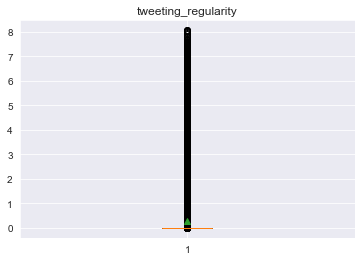

In [12]:
plot_boxplot(df_indicators[df_indicators.tweeting_regularity.notnull()],'tweeting_regularity')

# Maximum number of tweets in a day by user

Add new column which represents the date as the number of the day in the year (e.g. 1st of Janueary would be 1, 2nd of January would be 2, [...], 31st of December would be 365 or 366) concatenated to the year.
For example, 2nd of January of 2019 would be "2_2019".

In [13]:
df_tweets['day_of_year'] = pd.DatetimeIndex(df_tweets.created_at).day_of_year.map(str) + "_" + pd.DatetimeIndex(df_tweets.created_at).year.map(str)

In [14]:
df_tweets['day_of_year']

0           254_2019
1            92_2020
2           122_2019
3           308_2019
4            71_2020
              ...   
10187868    116_2019
10187869    108_2020
10187870    192_2016
10187871     66_2019
10187872    191_2019
Name: day_of_year, Length: 10187873, dtype: object

In [15]:
user_date_groupby = pd.DataFrame({'n_tweets_by_day' : df_tweets.groupby( [ 'user_id', 'day_of_year'] ).size()}).reset_index()

In [16]:
user_date_groupby

,user_id,day_of_year,n_tweets_by_day
0,000vk,118_2020,1
1,0013tom,99_2018,1
2,001gi,98_2020,1
3,001rx,70_2020,1
4,00201f,43_2019,1
...,...,...,...
1151381,zzyb,306_2019,1
1151382,zzyd6,170_2019,1
1151383,zzyyu,88_2020,1
1151384,zzz9v,106_2019,1


In [17]:
# Maximum number of tweets in a day
user_date_groupby[user_date_groupby['n_tweets_by_day'] == user_date_groupby['n_tweets_by_day'].max()]

,user_id,day_of_year,n_tweets_by_day
778142,492649414,115_2020,3238


Identify maximum number of tweets posted in a day for each user.

In [18]:
df_indicators['max_daily_tweets'] = user_date_groupby.groupby(by=['user_id']).agg({'n_tweets_by_day':max}).values

# Density of publication and other attributes

In [26]:
secs_in_min = 60
mins_in_hour = 60
hours_in_day = 24
secs_per_day = secs_in_min * mins_in_hour * hours_in_day
df_indicators['last_tweet_dates'] = df_tweets.groupby('user_id').agg({'created_at_conv':'max'}).values
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

def attribute_density(attr_total):
    """
    Compute the density for a given attribute as (total_amount)/user_activity_period.
    user_activity_period is defined as the time span from the user subscription to its latest tweet.
    :param attr_total:  the column name that contains the sum for the attribute. In this notebook it was computed along with mean, std and entropy.
    :return:
    """
    attr_density = df_merge.apply(lambda x: (x[attr_total]/((x.last_tweet_dates-x.created_at_conv)/secs_per_day)), axis=1)
    attr_density = preprocessing.MinMaxScaler().fit_transform(np.array(attr_density.values).reshape(1, -1).T)
    return attr_density

In [27]:
 for attr in df_merge.columns:
    if 'sum' in attr or attr=='n_tweets':
        print(attr)
        df_merge[f'{attr}'.replace('sum','density')] = attribute_density(attr)

n_tweets
created_at_conv_sum
retweet_count_sum
reply_count_sum
favorite_count_sum
num_hashtags_sum
num_urls_sum
num_mentions_sum


In [28]:
df_merge

,id,name,lang,bot,created_at,statuses_count,created_at_conv,user_id,n_tweets,2012_tweets,...,tweeting_regularity,max_daily_tweets,last_tweet_dates,created_at_conv_density,retweet_count_density,reply_count_density,favorite_count_density,num_hashtags_density,num_urls_density,num_mentions_density
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0,1550858442000000000,2353593986,0.000369,0.0,...,2.458470,17.0,1.564707e+18,0.000410,0.000000e+00,0.0,0.000016,0.003087,0.000000,0.001097
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54.0,1551150152000000000,2358850842,0.000335,0.0,...,2.504295,18.0,1.564733e+18,0.000372,3.292310e-07,0.0,0.000019,0.000726,0.000000,0.001214
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3.0,1430377796000000000,137959629,0.000003,0.0,...,0.060681,2.0,1.465646e+18,0.000003,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50.0,1484707758000000000,466124818,0.000612,0.0,...,1.657428,130.0,1.573753e+18,0.000685,0.000000e+00,0.0,0.000000,0.003952,0.000410,0.000044
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085.0,1560886221000000000,2571493866,0.005049,0.0,...,7.637613,47.0,1.588429e+18,0.005697,0.000000e+00,0.0,0.000000,0.051340,0.000132,0.026913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11503,2911861962,Madrid Lae Maika .,en,0,2019-11-29 13:16:02,1126.0,1575033362000000000,2911861962,0.003195,0.0,...,4.828845,52.0,1.588438e+18,0.003604,0.000000e+00,0.0,0.000000,0.052992,0.002449,0.024057
11504,1378532629,Clau Sato,en,0,2018-04-27 03:01:58,3024.0,1524798118000000000,1378532629,0.001258,0.0,...,4.181057,83.0,1.588155e+18,0.001393,0.000000e+00,0.0,0.000000,0.012509,0.003570,0.006912
11505,126984069,ALMA LETICIA NUÑO,es,0,2015-03-29 17:01:24,6.0,1427648484000000000,126984069,0.000003,0.0,...,0.919460,2.0,1.510973e+18,0.000003,0.000000e+00,0.0,0.000000,0.000079,0.000058,0.000010
11506,2383025796,Minnie Guadagno,en,1,2019-03-13 02:44:13,42.0,1552445053000000000,2383025796,0.000329,0.0,...,2.421923,10.0,1.564857e+18,0.000365,0.000000e+00,0.0,0.000028,0.000265,0.000000,0.001329


In [ ]:
df_indicators.drop(columns=['last_tweet_dates'], inplace=True)

# File Checkpoint

In [35]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_with_indicators.csv', sep='#', index=False)

In [36]:
df_indicators.to_csv(path_or_buf=DATA_PATH+'indicators.csv', sep='#', index=False)